# Analysis and Visualization on fp and quantized models

## 1. The keys in the model checkpoints

In [1]:
import torch

fp_dict = torch.load("../models/cnn_fp32_model.pth")
print("The FP model has", len(fp_dict.keys()), "keys. The keys in FP model dict are: ")
for key in fp_dict:
    print(key, fp_dict[key].dtype, fp_dict[key].size())

The FP model has 30 keys. The keys in FP model dict are: 
conv1.weight torch.float32 torch.Size([32, 1, 80])
conv1.bias torch.float32 torch.Size([32])
bn1.weight torch.float32 torch.Size([32])
bn1.bias torch.float32 torch.Size([32])
bn1.running_mean torch.float32 torch.Size([32])
bn1.running_var torch.float32 torch.Size([32])
bn1.num_batches_tracked torch.int64 torch.Size([])
conv2.weight torch.float32 torch.Size([32, 32, 3])
conv2.bias torch.float32 torch.Size([32])
bn2.weight torch.float32 torch.Size([32])
bn2.bias torch.float32 torch.Size([32])
bn2.running_mean torch.float32 torch.Size([32])
bn2.running_var torch.float32 torch.Size([32])
bn2.num_batches_tracked torch.int64 torch.Size([])
conv3.weight torch.float32 torch.Size([64, 32, 3])
conv3.bias torch.float32 torch.Size([64])
bn3.weight torch.float32 torch.Size([64])
bn3.bias torch.float32 torch.Size([64])
bn3.running_mean torch.float32 torch.Size([64])
bn3.running_var torch.float32 torch.Size([64])
bn3.num_batches_tracked torch.

In [2]:
qat_dict = torch.load("../models/cnn_qat_model.pth")
print("The QAT model has", len(qat_dict.keys()), "keys. The keys in qat model dict are: ")
for key in qat_dict:
    value = qat_dict[key]
    if isinstance(value, torch.Tensor):
        print(key, value.dtype, value.size())
    else:
        print(key, type(value))

The QAT model has 22 keys. The keys in qat model dict are: 
conv1.weight torch.qint8 torch.Size([32, 1, 80])
conv1.bias torch.float32 torch.Size([32])
conv1.scale torch.float32 torch.Size([])
conv1.zero_point torch.int64 torch.Size([])
conv2.weight torch.qint8 torch.Size([32, 32, 3])
conv2.bias torch.float32 torch.Size([32])
conv2.scale torch.float32 torch.Size([])
conv2.zero_point torch.int64 torch.Size([])
conv3.weight torch.qint8 torch.Size([64, 32, 3])
conv3.bias torch.float32 torch.Size([64])
conv3.scale torch.float32 torch.Size([])
conv3.zero_point torch.int64 torch.Size([])
conv4.weight torch.qint8 torch.Size([64, 64, 3])
conv4.bias torch.float32 torch.Size([64])
conv4.scale torch.float32 torch.Size([])
conv4.zero_point torch.int64 torch.Size([])
fc1.scale torch.float32 torch.Size([])
fc1.zero_point torch.int64 torch.Size([])
fc1._packed_params.dtype <class 'torch.dtype'>
fc1._packed_params._packed_params <class 'tuple'>
quant.scale torch.float32 torch.Size([1])
quant.zero_point

/root/miniconda3/envs/audioml/lib/python3.13/site-packages/torch/_utils.py:431: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


In [3]:
ptq_dict = torch.load("../models/cnn_ptq_model.pth")
print("The PTQ model has", len(ptq_dict.keys()), "keys. The keys in PTQ model dict are: ")
for key in ptq_dict:
    value = ptq_dict[key]
    if isinstance(value, torch.Tensor):
        print(key, value.dtype, value.size())
    else:
        print(key, type(value))


The PTQ model has 22 keys. The keys in PTQ model dict are: 
conv1.weight torch.qint8 torch.Size([32, 1, 80])
conv1.bias torch.float32 torch.Size([32])
conv1.scale torch.float32 torch.Size([])
conv1.zero_point torch.int64 torch.Size([])
conv2.weight torch.qint8 torch.Size([32, 32, 3])
conv2.bias torch.float32 torch.Size([32])
conv2.scale torch.float32 torch.Size([])
conv2.zero_point torch.int64 torch.Size([])
conv3.weight torch.qint8 torch.Size([64, 32, 3])
conv3.bias torch.float32 torch.Size([64])
conv3.scale torch.float32 torch.Size([])
conv3.zero_point torch.int64 torch.Size([])
conv4.weight torch.qint8 torch.Size([64, 64, 3])
conv4.bias torch.float32 torch.Size([64])
conv4.scale torch.float32 torch.Size([])
conv4.zero_point torch.int64 torch.Size([])
fc1.scale torch.float32 torch.Size([])
fc1.zero_point torch.int64 torch.Size([])
fc1._packed_params.dtype <class 'torch.dtype'>
fc1._packed_params._packed_params <class 'tuple'>
quant.scale torch.float32 torch.Size([1])
quant.zero_point

The keys in the quantized model are different from the keys in the FP model. The difference is due to the following reasons:
-  BatchNorm Folding: 

    --`bn.weight`, `bn.bias`, `running_mean`, `running_var`

    During QAT, BatchNorm layers are fused with their corresponding `Conv1d` layers using `fuse_model()`. And the running statistics and batch norm parameters are folded into the `Conv1d` weights and biases. 

- Quantization Related Parameters: 

    ++`convX.scale`, `convX.zero_point`

- FC Parameters Packing: 

    --`fc1.weight`, `fc1.bias` 

    ++`fc1._packed_params.dtype`, `fc1._packed_params`, `fc1.scale`, `fc1.zero_point`

    Since the `nn.Linear` in fp model is replaced by `torch.ao.nn.qat.Linear` the quantized version, the keys of fc layers varied. 

    - `fc1._packed_params.dtype` stores the data type of the quantized weights in `fc1` (i.e. `torch.qint8`). 
    - `fc1._packed_params._packed_params` has 2 elements. The first one is quantized weight tensor, indicating its quantization scheme, scale and zero_point for each channel as well. The second one element is the bias tensor in float32. Usually the bias are not quantized.




In [5]:
print(len(qat_dict["fc1._packed_params._packed_params"]))
print(len(ptq_dict["fc1._packed_params._packed_params"]))

print(qat_dict["fc1._packed_params._packed_params"][0].dtype)
print(ptq_dict["fc1._packed_params._packed_params"][0].dtype)

print(qat_dict["fc1._packed_params._packed_params"][0].type())
print(ptq_dict["fc1._packed_params._packed_params"][0].type())

print(qat_dict["fc1._packed_params._packed_params"][0].size())
print(ptq_dict["fc1._packed_params._packed_params"][0].size())

print(qat_dict["fc1._packed_params._packed_params"][0])
print(ptq_dict["fc1._packed_params._packed_params"][0])

print(qat_dict["fc1._packed_params._packed_params"][1].dtype)
print(ptq_dict["fc1._packed_params._packed_params"][1].dtype)

print(qat_dict["fc1._packed_params._packed_params"][1].type())
print(ptq_dict["fc1._packed_params._packed_params"][1].type())

print(qat_dict["fc1._packed_params._packed_params"][1].size())
print(ptq_dict["fc1._packed_params._packed_params"][1].size())

print(qat_dict["fc1.scale"])
print(ptq_dict["fc1.scale"])

print(qat_dict["fc1.zero_point"])
print(ptq_dict["fc1.zero_point"])


2
2
torch.qint8
torch.qint8
torch.quantized.QInt8Tensor
torch.quantized.QInt8Tensor
torch.Size([35, 64])
torch.Size([35, 64])
tensor([[ 0.0344, -0.1279, -0.1894,  ...,  0.0000, -0.0271,  0.0025],
        [-0.0525, -0.0739,  0.0447,  ...,  0.0000, -0.0311, -0.0097],
        [-0.0202, -0.0173,  0.1080,  ...,  0.0000,  0.0086, -0.0043],
        ...,
        [-0.1384, -0.0336,  0.1285,  ...,  0.0000,  0.0040, -0.0040],
        [-0.0579,  0.1221,  0.0150,  ...,  0.0000, -0.0450,  0.0000],
        [ 0.1803,  0.0767,  0.0690,  ...,  0.0000, -0.0096,  0.0058]],
       size=(35, 64), dtype=torch.qint8,
       quantization_scheme=torch.per_channel_affine,
       scale=tensor([0.0025, 0.0019, 0.0014, 0.0017, 0.0014, 0.0020, 0.0024, 0.0021, 0.0020,
        0.0018, 0.0020, 0.0015, 0.0027, 0.0019, 0.0021, 0.0019, 0.0027, 0.0024,
        0.0016, 0.0022, 0.0022, 0.0020, 0.0020, 0.0022, 0.0028, 0.0019, 0.0018,
        0.0020, 0.0020, 0.0016, 0.0022, 0.0022, 0.0020, 0.0021, 0.0019],
       dtype=torch.f

### Overall
| Components | FP32 model keys (30) | QAT model keys (22) | PTQ model keys (22) |
| --- | --- | --- | --- |
| Convolution layers | `convX.weight`, `convX.bias` | `convX.weight`, `convX.bias`, `convX.scale`, `convX.zero_point` | same as QAT |
| BatchNorm layers | `bnX.weight`, `bnX.bias`, `bnX.running_mean`, `bnX.running_var` | Folded into `convX` | same as QAT |
| FC layers | `fc1.weight`, `fc1.bias` | `fc1.scale`, `fc1.zero_point`, `fc1._packed_params.dtype`, `fc1._packed_params` | same as QAT |
| Quant Stubs |  | `quant.scale`, `quant.zero_point` | same as QAT |

## Evaluation Results

Run after comment `@profile`:

```python

python src/evaluate.py --checkpoint models/cnn_fp32_model.pth --config configs/cnn_fp32.yaml

python src/evaluate.py --checkpoint models/cnn_qat_model.pth --config configs/cnn_qat.yaml

python src/evaluate.py --checkpoint models/cnn_ptq_model.pth --config configs/cnn_ptq.yaml

```

| Metrics | FP32 | PTQ (Static) | QAT (from Checkpoint) |
| --- | --- | --- | --- |
| Model Size | 116.98 KB | 40.51 KB (2.89x) | ~~40.01 KB (≈2.9x)~~(TO BE UPDATED) |
| Accuracy | 83.07% | 75.85% (↓8.69%) | ~~77.94% (↓4.37%)~~(TO BE UPDATED) |
| Inference Time* | 15.744ms | 3.382ms (≈4.7x) | - | 

### 1. Accuracy

Here I use the test_loader in `SpeechCommand` dataset:
- Test loader length: 11005
- Test loader batches: 43
- Test loader batch size: 256

### 2. Inference Time

Here I use `line_profiler` to analyze the inference time in `test` function by: 

``` bash
kernprof -l -v -o logs/profiling_logs/qat_profiling.lprof src/evaluate.py --checkpoint ./models/cnn_qat_model.pth --config ./configs/cnn_qat.yaml
```

And I got:

```

Timer unit: 1e-06 s
Total time: 21.0433 s
File: src/evaluate.py
Function: test at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    52                                           @profile
    53                                           def test(model, test_loader):
    54         1        175.0    175.0      0.0      model.eval()
    55         1          0.1      0.1      0.0      correct = 0
    56         2         32.2     16.1      0.0      with torch.no_grad():
    57        44   20875165.1 474435.6     99.2          for data, target in test_loader:
    58        43        483.3     11.2      0.0              data, target = data.to(device), target.to(device)
    59        43     162906.2   *3788.5*      0.8              output = model(data)
    60        43       2214.8     51.5      0.0              pred = get_likely_index(output)
    61        43       2328.0     54.1      0.0              correct += number_of_correct(pred, target)
    62         1          4.8      4.8      0.0      accuracy = 100. * correct / len(test_loader.dataset)
    63         1          0.7      0.7      0.0      return accuracy
```


Here I use the time per hit of line 59 as the average inference time, i.e. 3.788ms

Likewise the result of fp32:

``` bash
kernprof -l -v -o logs/profiling_logs/fp32_profiling.lprof src/evaluate.py --checkpoint ./models/cnn_fp32_model.pth --config ./configs/cnn_fp32.yaml
```

And I got:

```
Timer unit: 1e-06 s
Total time: 21.9024 s
File: src/evaluate.py
Function: test at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    52                                           @profile
    53                                           def test(model, test_loader):
    54         1        165.0    165.0      0.0      model.eval()
    55         1          0.2      0.2      0.0      correct = 0
    56         2         26.0     13.0      0.0      with torch.no_grad():
    57        44   21220067.8 482274.3     96.9          for data, target in test_loader:
    58        43        558.4     13.0      0.0              data, target = data.to(device), target.to(device)
    59        43     677012.1  *15744.5*      3.1              output = model(data)
    60        43       2200.7     51.2      0.0              pred = get_likely_index(output)
    61        43       2398.1     55.8      0.0              correct += number_of_correct(pred, target)
    62         1          7.3      7.3      0.0      accuracy = 100. * correct / len(test_loader.dataset)
    63         1          0.8      0.8      0.0      return accuracy
```

and static quantization:

``` bash 
kernprof -l -v -o logs/profiling_logs/ptq_profiling.lprof src/evaluate.py --checkpoint ./models/cnn_ptq_model.pth --config ./configs/cnn_ptq.yaml
```

and I got:

```
Timer unit: 1e-06 s

Total time: 20.0763 s
File: src/evaluate.py
Function: test at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    52                                           @profile
    53                                           def test(model, test_loader):
    54         1        177.1    177.1      0.0      model.eval()
    55         1          0.2      0.2      0.0      correct = 0
    56         2         34.7     17.4      0.0      with torch.no_grad():
    57        44   19925933.9 452862.1     99.3          for data, target in test_loader:
    58        43        494.9     11.5      0.0              data, target = data.to(device), target.to(device)
    59        43     145440.8   3382.3      0.7              output = model(data)
    60        43       2050.5     47.7      0.0              pred = get_likely_index(output)
    61        43       2193.1     51.0      0.0              correct += number_of_correct(pred, target)
    62         1          4.9      4.9      0.0      accuracy = 100. * correct / len(test_loader.dataset)
    63         1          0.7      0.7      0.0      return accuracy

```


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

with open('../history.json', 'r') as fp:
    history = json.load(fp)

print("Keys in history:", history.keys())
train_loss = history['train_loss']
test_loss = history['test_loss']
test_acc = history['test_acc']

print(len(train_loss))
print(len(test_loss))
print(len(test_acc))


Keys in history: dict_keys(['train_loss', 'test_loss', 'test_acc'])
30
10
10


In [3]:
from src.data_loader import get_data_loaders
config = {
  "data": {
    "raw_dir": "../data/raw",
    "sample_rate": 8000,
    "batch_size": 256,
    "version": "v0.1"
  }
}
train_loader, test_loader, validate_loader = get_data_loaders(config["data"])

# single_batch_length = []

# for batch_idx, batch in enumerate(train_loader):
#     single_batch_length.append(len(batch[1]))
# print("Length of each batch in train_loader:", single_batch_length)

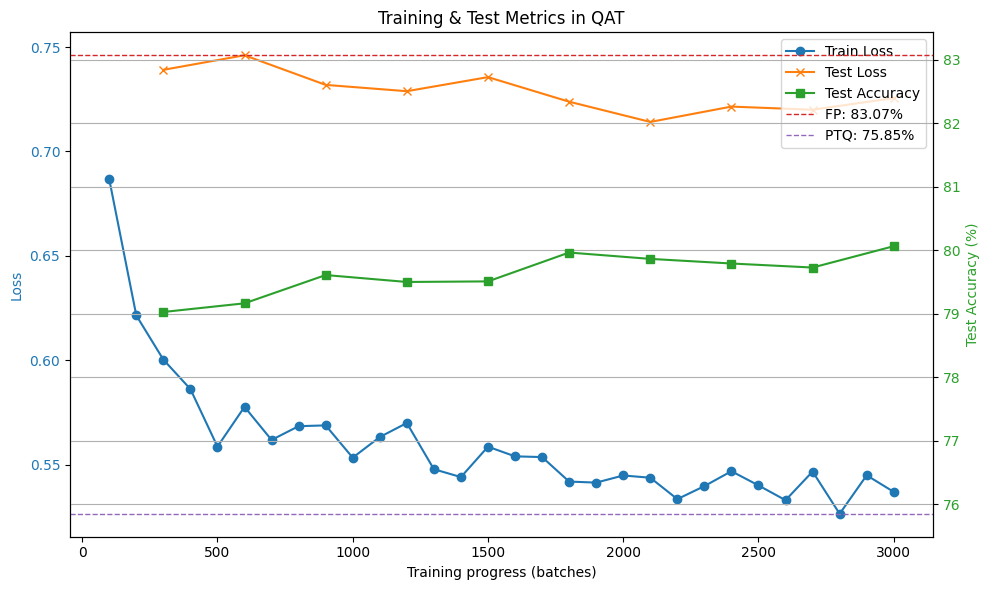

In [ ]:
batch_interval = 100
train_x = np.arange(1, len(train_loss) + 1) * batch_interval
epochs = np.arange(1, len(test_loss) + 1)

# Reference accuracies
acc_fp = 83.07
acc_ptq = 75.85

fig, ax1 = plt.subplots(figsize=(10, 6))

# --- Train loss ---
ax1.set_xlabel("Training progress (batches)")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.plot(train_x, train_loss, label="Train Loss", color="tab:blue", marker="o")
ax1.plot(epochs * (len(train_x) / len(epochs) * batch_interval),
         test_loss, label="Test Loss", color="tab:orange", marker="x")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# --- Test accuracy on second axis ---
ax2 = ax1.twinx()
ax2.set_ylabel("Test Accuracy (%)", color="tab:green")
ax2.plot(epochs * (len(train_x) / len(epochs) * batch_interval),
         np.array(test_acc) * 100, label="Test Accuracy", color="tab:green", marker="s")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Reference lines
ax2.axhline(y=acc_fp, color="tab:red", linestyle="--", linewidth=1, label=f"FP: {acc_fp:.2f}%")
ax2.axhline(y=acc_ptq, color="tab:purple", linestyle="--", linewidth=1, label=f"PTQ: {acc_ptq:.2f}%")

# Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("Accuracy and Loss in QAT.")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
! pip install seaborn -q

In [38]:
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def count_labels(dataloader):
    counts = Counter()
    for _, targets in dataloader:
        targets = targets.view(-1).tolist()
        counts.update(targets)
    return counts

def plot_label_heatmap(train_loader, val_loader, test_loader, labels):
    # Count labels
    train_counts = count_labels(train_loader)
    val_counts = count_labels(val_loader)
    test_counts = count_labels(test_loader)

    all_labels = list(range(len(labels)))

    # Build raw matrix (3 x n_classes)
    data_matrix = np.array([
        [train_counts.get(lbl, 0) for lbl in all_labels],
        [val_counts.get(lbl, 0) for lbl in all_labels],
        [test_counts.get(lbl, 0) for lbl in all_labels]
    ], dtype=float)

    # Normalize each row to sum = 1 (percentage distribution)
    row_sums = data_matrix.sum(axis=1, keepdims=True)
    normalized_matrix = 100 * data_matrix / row_sums

    annot_labels = np.array(
        [[f"{val:.2f}" for val in row] for row in normalized_matrix]
    )

    # Row labels
    row_labels = ["Train", "Validation", "Test"]

    plt.figure(figsize=(15, 3))
    ax = sns.heatmap(
        normalized_matrix,
        annot=annot_labels, fmt="", cmap="Reds",
        xticklabels=[f"{i}. {name}" for i, name in enumerate(labels)],
        yticklabels=row_labels,
        cbar_kws={'label': 'Proportion per split (%)'}, 
        vmin=0, vmax=5
    )

    ax.set_xlabel("Labels")
    plt.title("Normalized Label Distribution in SpeechCommands Dataset")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return train_counts, val_counts, test_counts


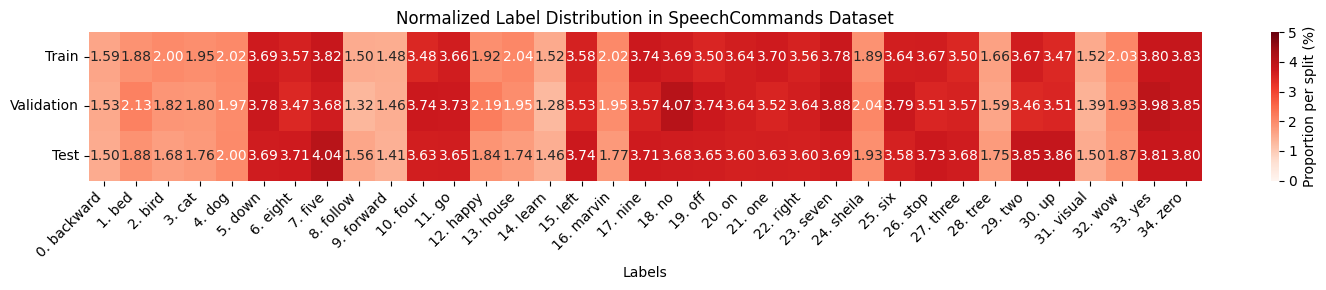

In [39]:
from src.data_loader import SubsetSC
temp_set = SubsetSC("testing", root = "../data/raw")
labels = sorted(list(set(d[2] for d in temp_set)))
train_counts, val_counts, test_counts = plot_label_heatmap(train_loader, validate_loader, test_loader, labels)